## 2a)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load('data/FilteredRecording.npy')
data.shape, data

((54000403,),
 array([ 0.        ,  0.        ,  0.        , ..., -4.87033603,
        -2.74986436, -0.51281699]))

We threshold the data using a boolean mask and then find the start of each segment by comparing each element with the previous one and then filter to check that for each potential starting index, the segment of length 80 is actually valid.

In [2]:
above_threshold = data > 95

shifted_mask = np.concatenate(([False], above_threshold[:-1]))
start_indices = np.where(above_threshold & (~shifted_mask))[0]

valid_start_indices = start_indices[(start_indices >= 40) & (start_indices + 40 < len(data))]

print(f"Found {len(valid_start_indices)} segments above the threshold.")

Found 18409 segments above the threshold.


In [3]:
segments = [data[t-40 : t+40] for t in valid_start_indices]
Z = np.array(segments)  # Shape: (n, 80)

print(f"Shape of Z: {Z.shape}")

plt.figure(figsize=(12, 6))
num_plots = min(20, Z.shape[0])
for i in range(num_plots):
    plt.plot(Z[i], label=f"Segment {i+1}")

plt.xlabel("Time Index (relative to t)")
plt.ylabel("Data Value")
plt.title("Sample 80-Point Segments Extracted from Data")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Shape of Z: (18409, 80)


## 2b)

New shape of Y: (18329, 50)


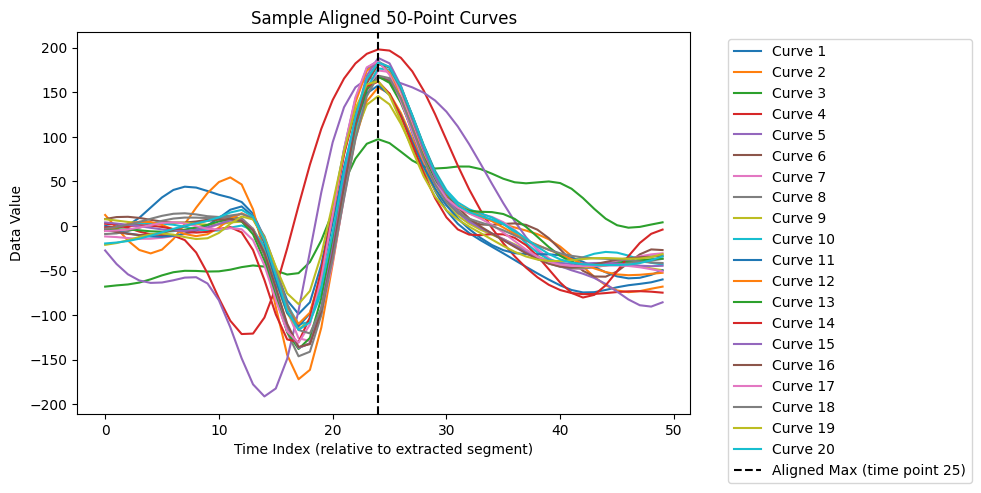

In [4]:
aligned_segments = []  # to collect the aligned (centered) curves

# Iterate over each extracted 80-point curve in Z
for segment in Z:
    # Find the index of the maximum value in the segment
    i_max = np.argmax(segment)
    
    # Check if there are sufficient points on both sides:
    # We need at least 24 points before the maximum and 25 points after.
    if i_max < 24 or (i_max + 26) > len(segment):
        # If not, drop the sample (i.e., skip this segment)
        continue
    
    # Extract a 50-point segment centered on the maximum.
    # This takes indices from i_max-24 to i_max+26 (50 points total)
    new_segment = segment[i_max - 24 : i_max + 26]
    aligned_segments.append(new_segment)

# Convert the list of aligned segments to a numpy array
Y = np.array(aligned_segments)
print("New shape of Y:", Y.shape)

# We plot a few of the aligned curves to verify the alignment
plt.figure(figsize=(10, 5))
num_plots = min(20, Y.shape[0])
for i in range(num_plots):
    plt.plot(Y[i], label=f"Curve {i+1}")

# Mark the expected maximum position (index 24) on the plot
plt.axvline(x=24, color='k', linestyle='--', label='Aligned Max (time point 25)')
plt.xlabel("Time Index (relative to extracted segment)")
plt.ylabel("Data Value")
plt.title("Sample Aligned 50-Point Curves")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 2c)

In [5]:
from sklearn.cluster import KMeans

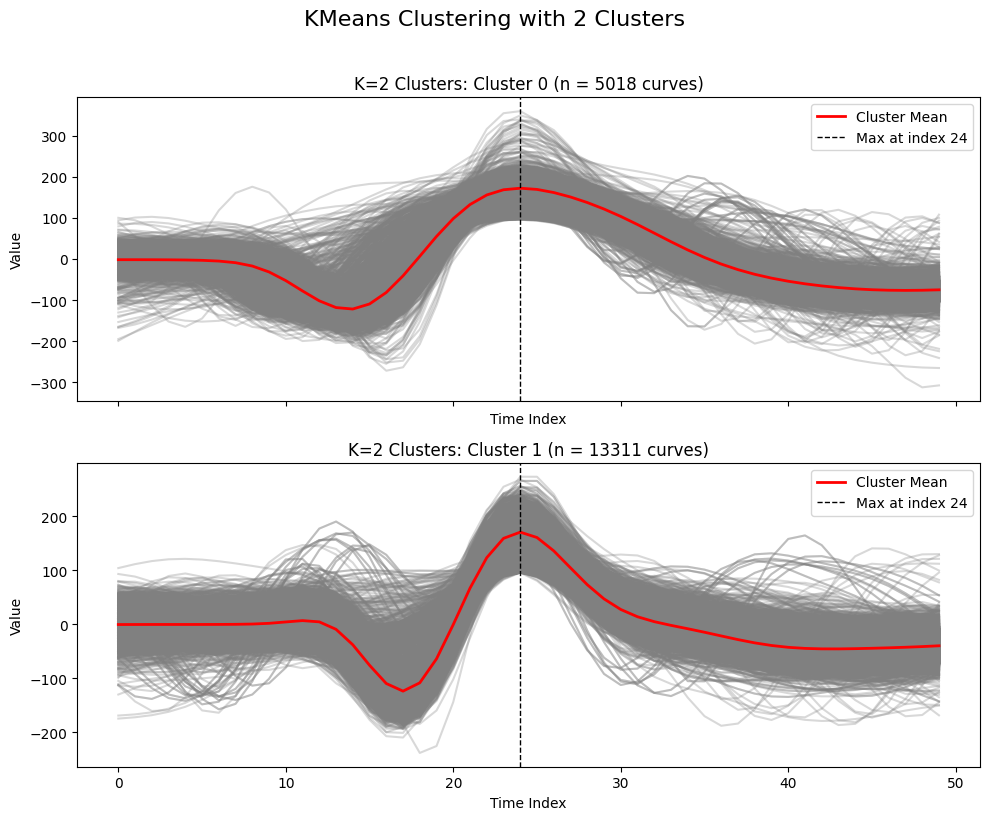

In [6]:
cluster_numbers = [2, 3, 4]

for k in cluster_numbers:
    # We perform KMeans clustering with k clusters.
    kmeans = KMeans(n_clusters=k, random_state=42)
    assignments = kmeans.fit_predict(Y)
    
    # Create a figure with one subplot per cluster.
    fig, axs = plt.subplots(k, 1, figsize=(10, 4 * k), sharex=True)
    
    # Ensure axs is iterable (it is an array even for k == 1).
    if k == 1:
        axs = [axs]
    
    # Plot each cluster's curves.
    for cluster in range(k):
        # Select curves belonging to the current cluster.
        cluster_curves = Y[assignments == cluster]
        # Compute the mean curve for the cluster.
        cluster_mean = cluster_curves.mean(axis=0)
        
        ax = axs[cluster]
        # Plot all curves in light gray.
        for curve in cluster_curves:
            ax.plot(curve, color='gray', alpha=0.3)
        # Overlay the cluster mean curve in red.
        ax.plot(cluster_mean, color='red', linewidth=2, label='Cluster Mean')
        # Mark the index of the aligned maximum with a dashed line.
        ax.axvline(x=24, color='k', linestyle='--', linewidth=1, label='Max at index 24')
        ax.set_title(f"K={k} Clusters: Cluster {cluster} (n = {cluster_curves.shape[0]} curves)")
        ax.set_xlabel("Time Index")
        ax.set_ylabel("Value")
        ax.legend(loc='upper right')
    
    fig.suptitle(f"KMeans Clustering with {k} Clusters", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

## 2d)

In [7]:
def custom_pca(X, num_components=2):
    """
    Perform PCA on data X and return the projection onto the first num_components principal components.
    
    Parameters:
    - X: numpy array of shape (m, d) where m is the number of samples and d is the number of features.
    - num_components: number of principal components to project onto.
    
    Returns:
    - transformed_data: the projection of X onto the top num_components principal components.
    - eigenvalues: eigenvalues of the covariance matrix sorted in descending order.
    - eigenvectors: corresponding eigenvectors sorted accordingly.
    """
    # Mean-center the data (subtract the mean of each column)
    X_centered = X - np.mean(X, axis=0)
    
    # Compute the covariance matrix.
    # Using np.cov with rowvar=False means each column represents a variable.
    cov_matrix = np.cov(X_centered, rowvar=False)
    
    # Compute eigenvalues and eigenvectors.
    # Using 'eigh' because the covariance matrix is symmetric.
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Sort the eigenvalues and eigenvectors in descending order.
    sorted_idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_idx]
    eigenvectors = eigenvectors[:, sorted_idx]
    
    # Project the centered data onto the first num_components eigenvectors.
    components = eigenvectors[:, :num_components]
    transformed_data = np.dot(X_centered, components)
    
    return transformed_data, eigenvalues, eigenvectors

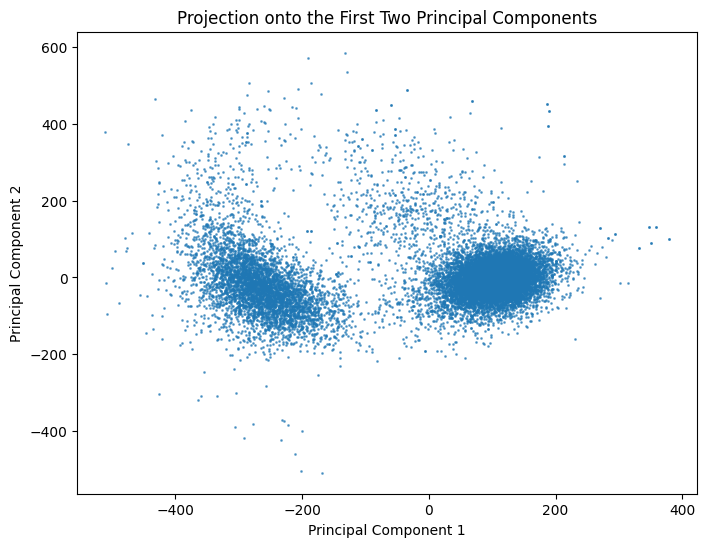

In [8]:
# Apply our custom PCA routine to obtain the first 2 principal components.
proj_data, eigenvalues, eigenvectors = custom_pca(Y, num_components=2)

# Plot the projection.
plt.figure(figsize=(8, 6))
# Using very small dots (s=1) to better see the structure.
plt.scatter(proj_data[:, 0], proj_data[:, 1], s=1, alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Projection onto the First Two Principal Components")
plt.show()

## 2e)

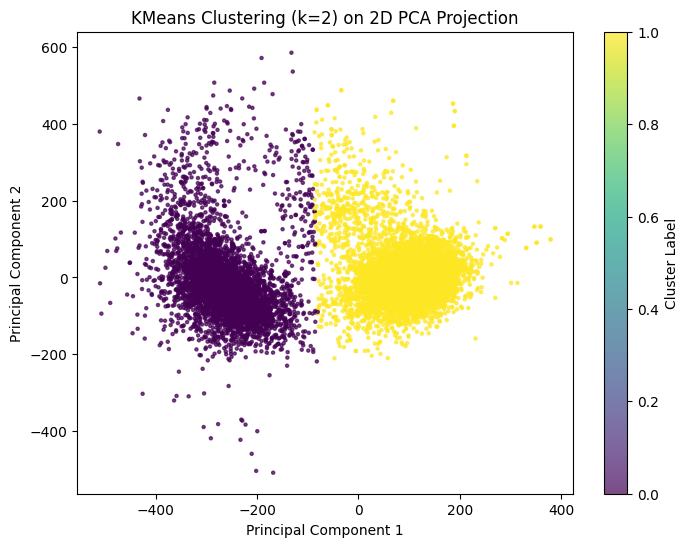

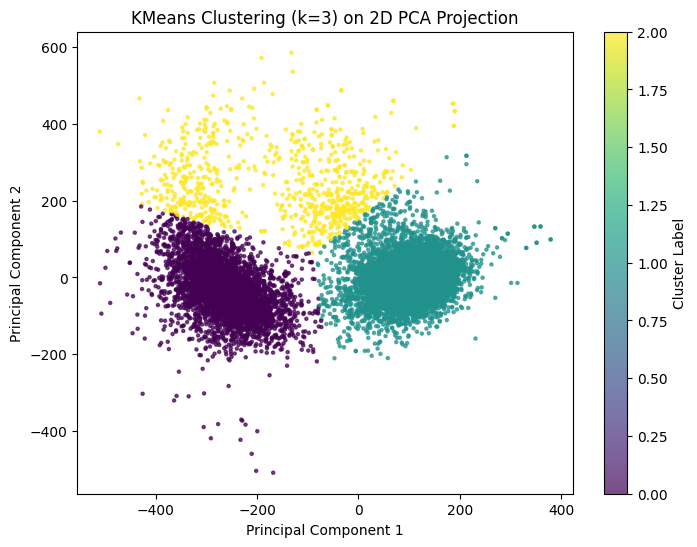

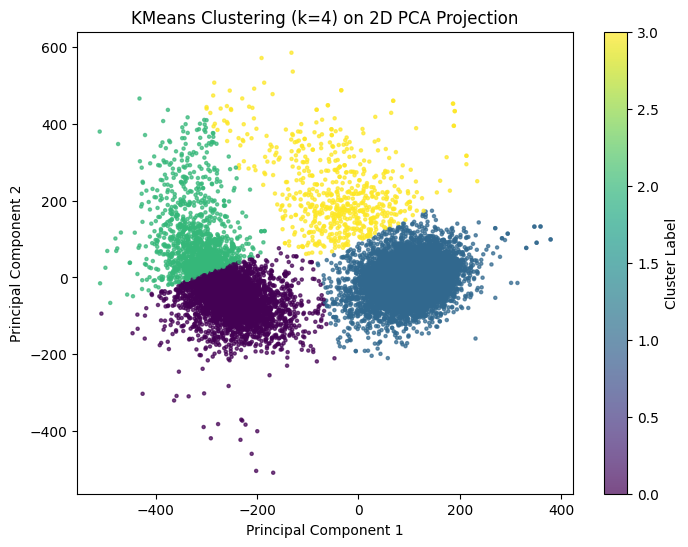

In [9]:
cluster_numbers = [2, 3, 4]

# Loop over different values of k.
for k in cluster_numbers:
    # Initialize and fit KMeans clustering.
    kmeans = KMeans(n_clusters=k, random_state=42)
    assignments = kmeans.fit_predict(proj_data)
    
    # Create a scatter plot of the data points colored by their cluster assignment.
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(proj_data[:, 0], proj_data[:, 1], 
                          c=assignments, cmap='viridis', s=5, alpha=0.7)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title(f"KMeans Clustering (k={k}) on 2D PCA Projection")
    cbar = plt.colorbar(scatter)
    cbar.set_label("Cluster Label")
    plt.show()

## 2f)

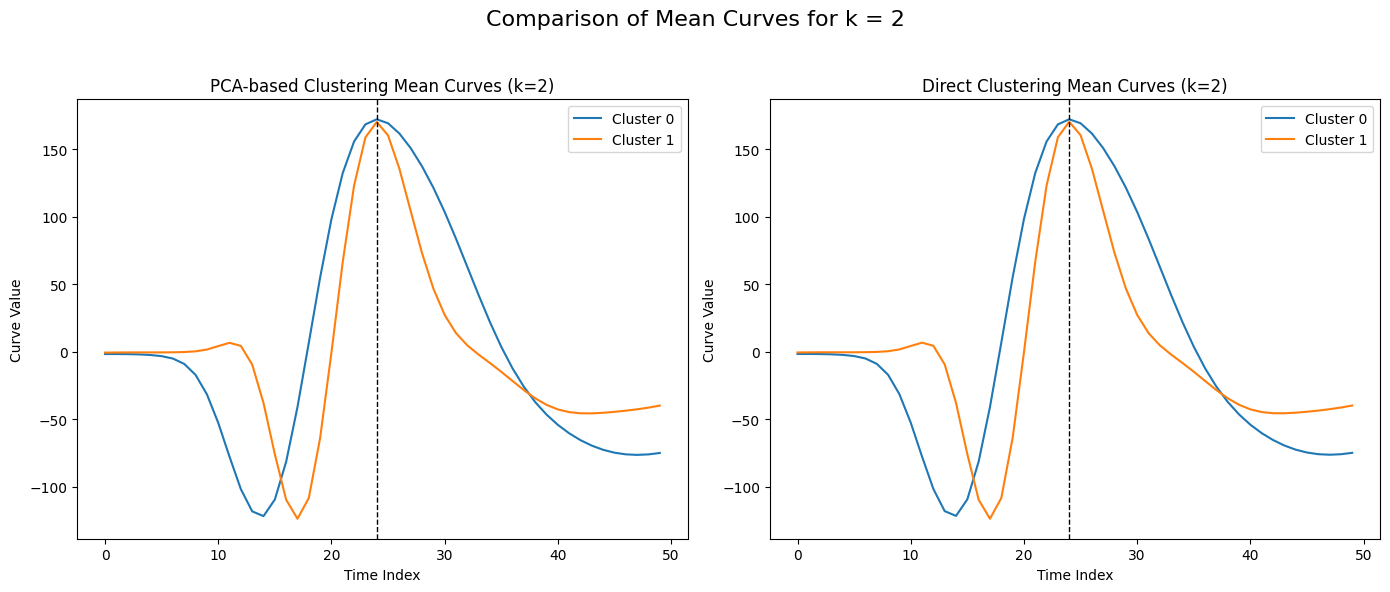

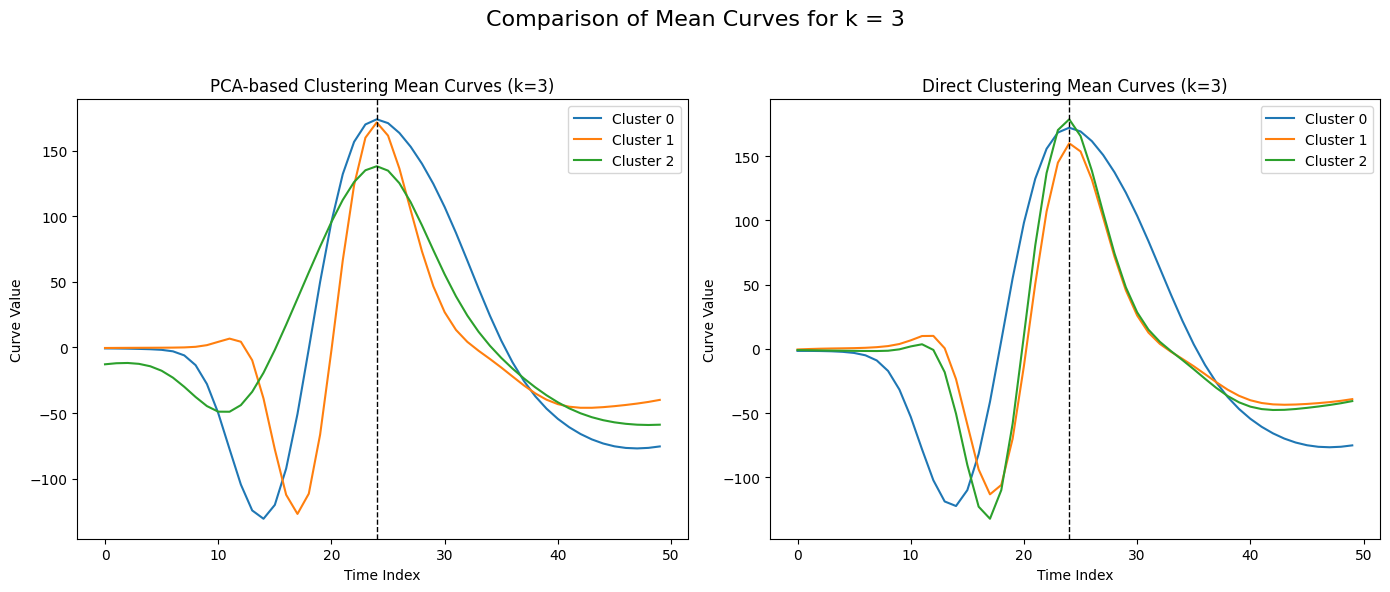

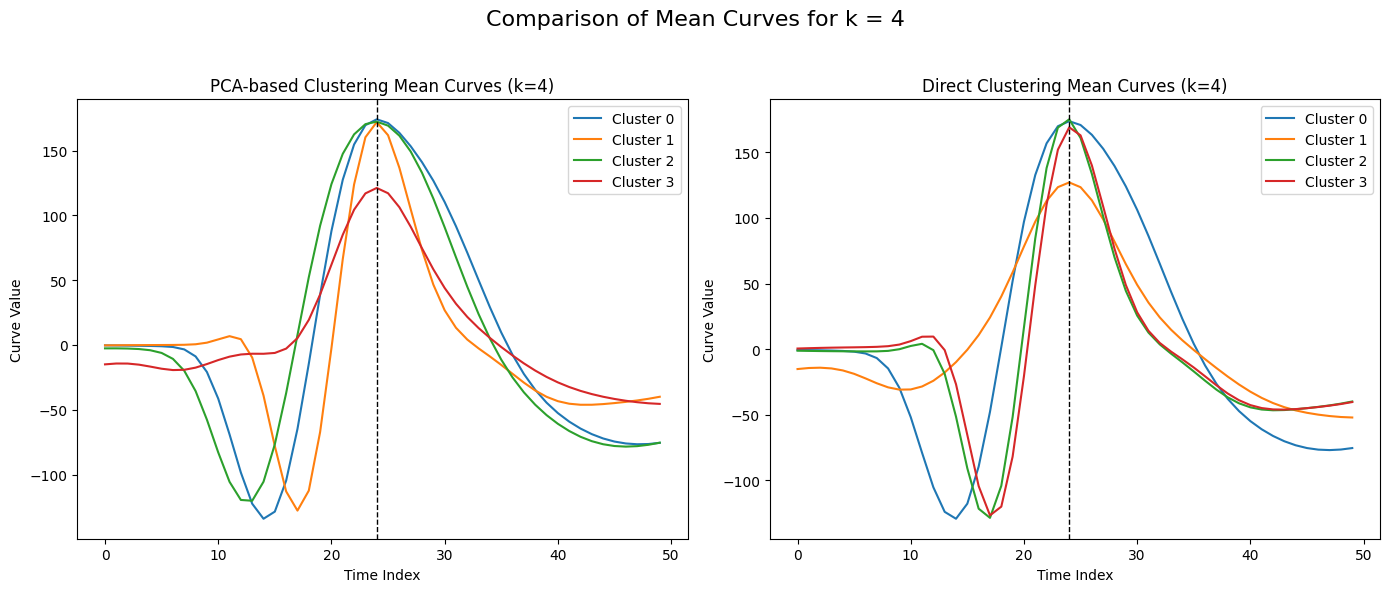

In [10]:
# List of cluster numbers we want to compare.
cluster_numbers = [2, 3, 4]

for k in cluster_numbers:
    # ===========================
    # Clustering via PCA Projections
    # ===========================
    kmeans_pca = KMeans(n_clusters=k, random_state=42)
    pca_assignments = kmeans_pca.fit_predict(proj_data)
    
    # Compute mean curves from PCA-based cluster assignments.
    pca_mean_curves = []
    for cluster in range(k):
        cluster_curves = Y[pca_assignments == cluster]
        if cluster_curves.shape[0] > 0:
            mean_curve = np.mean(cluster_curves, axis=0)
            pca_mean_curves.append(mean_curve)
        else:
            pca_mean_curves.append(np.zeros(Y.shape[1]))  # safety fallback
    
    # ===========================
    # Direct Clustering on the Curves
    # ===========================
    kmeans_direct = KMeans(n_clusters=k, random_state=42)
    direct_assignments = kmeans_direct.fit_predict(Y)
    
    # Compute mean curves from direct clustering.
    direct_mean_curves = []
    for cluster in range(k):
        cluster_curves_direct = Y[direct_assignments == cluster]
        if cluster_curves_direct.shape[0] > 0:
            mean_curve_direct = np.mean(cluster_curves_direct, axis=0)
            direct_mean_curves.append(mean_curve_direct)
        else:
            direct_mean_curves.append(np.zeros(Y.shape[1]))
    
    # ===========================
    # Plotting the results side by side for comparison
    # ===========================
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot mean curves from PCA-based clustering.
    for cluster in range(k):
        axs[0].plot(pca_mean_curves[cluster], label=f'Cluster {cluster}')
    axs[0].set_title(f'PCA-based Clustering Mean Curves (k={k})')
    axs[0].set_xlabel("Time Index")
    axs[0].set_ylabel("Curve Value")
    axs[0].legend()
    axs[0].axvline(x=24, color='k', linestyle='--', linewidth=1, label="Aligned Peak (index 24)")
    
    # Plot mean curves from direct clustering on the curves.
    for cluster in range(k):
        axs[1].plot(direct_mean_curves[cluster], label=f'Cluster {cluster}')
    axs[1].set_title(f'Direct Clustering Mean Curves (k={k})')
    axs[1].set_xlabel("Time Index")
    axs[1].set_ylabel("Curve Value")
    axs[1].legend()
    axs[1].axvline(x=24, color='k', linestyle='--', linewidth=1, label="Aligned Peak (index 24)")
    
    plt.suptitle(f'Comparison of Mean Curves for k = {k}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

We observe that the PCA-based mean curves are generally smoother, which makes sense since PCA would filter out some of the noise or less-variant features. Conversely, the direct clustering approach might be able to capture more of the detailed behavior by using some of these less dominant features. 

## 3a)

In [11]:
mnist_data = np.load('data/MNIST_data.npy')
mnist_labels = np.load('data/MNIST_labels.npy')

mnist_data = mnist_data / 255
mnist_data_training = mnist_data[:int(len(mnist_data)*0.8)]
mnist_data_test = mnist_data[int(len(mnist_data)*0.8):]
mnist_data.shape, mnist_data_training.shape, mnist_data_test.shape, mnist_labels.shape

((70000, 784), (56000, 784), (14000, 784), (70000,))

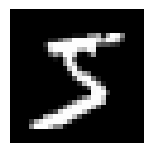

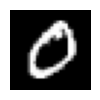

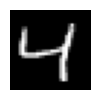

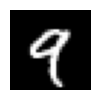

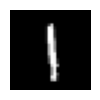

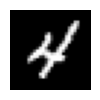

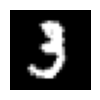

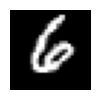

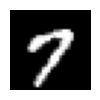

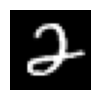

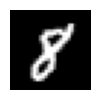

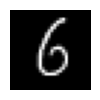

In [12]:
examples = mnist_data_training
nrows = 4
ncols = 5

plt.figure(figsize=(ncols*2, nrows*2))
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(examples[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    plt.show()

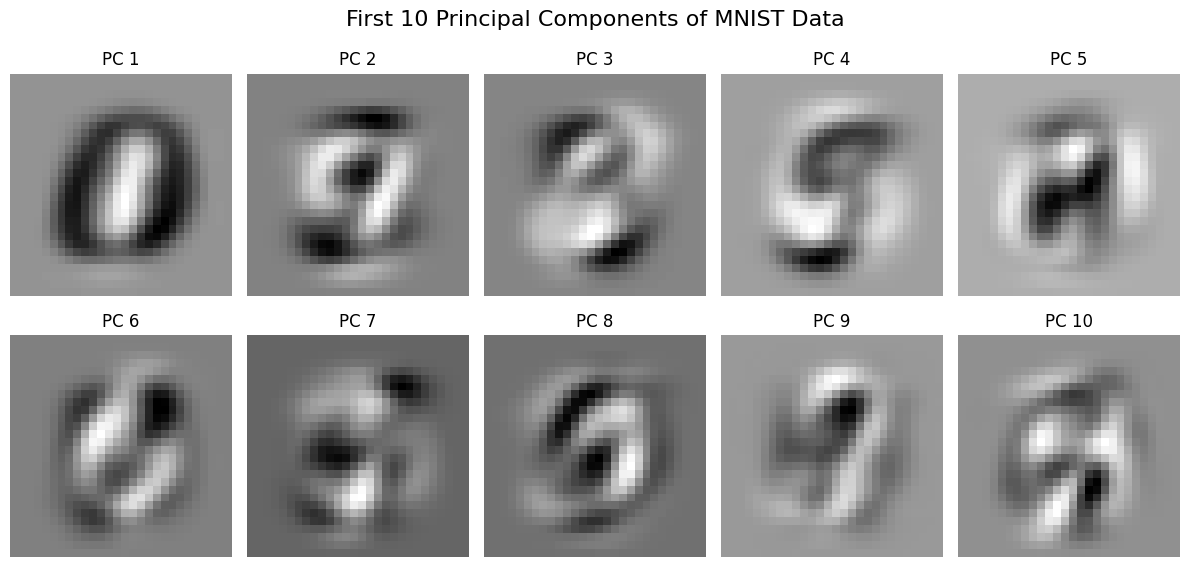

In [13]:
proj_data, eigenvalues, eigenvectors = custom_pca(mnist_data_training)

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Reshape each principal component (a 784-vector) into a 28x28 image.
    pc_image = eigenvectors[:, i].reshape(28, 28)
    plt.imshow(pc_image, cmap='gray')
    plt.title(f'PC {i+1}')
    plt.axis('off')
plt.suptitle("First 10 Principal Components of MNIST Data", fontsize=16)
plt.tight_layout()
plt.show()

## 3b)

In [14]:
# Plot the eigenvalues to show the variance explained by each principal component.
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-')
plt.xlabel('Principal Component Number')
plt.ylabel('Variance Explained (Eigenvalue)')
plt.title('Variance Explained by Principal Components (MNIST)')
plt.grid(True)
plt.show()

## 3c)

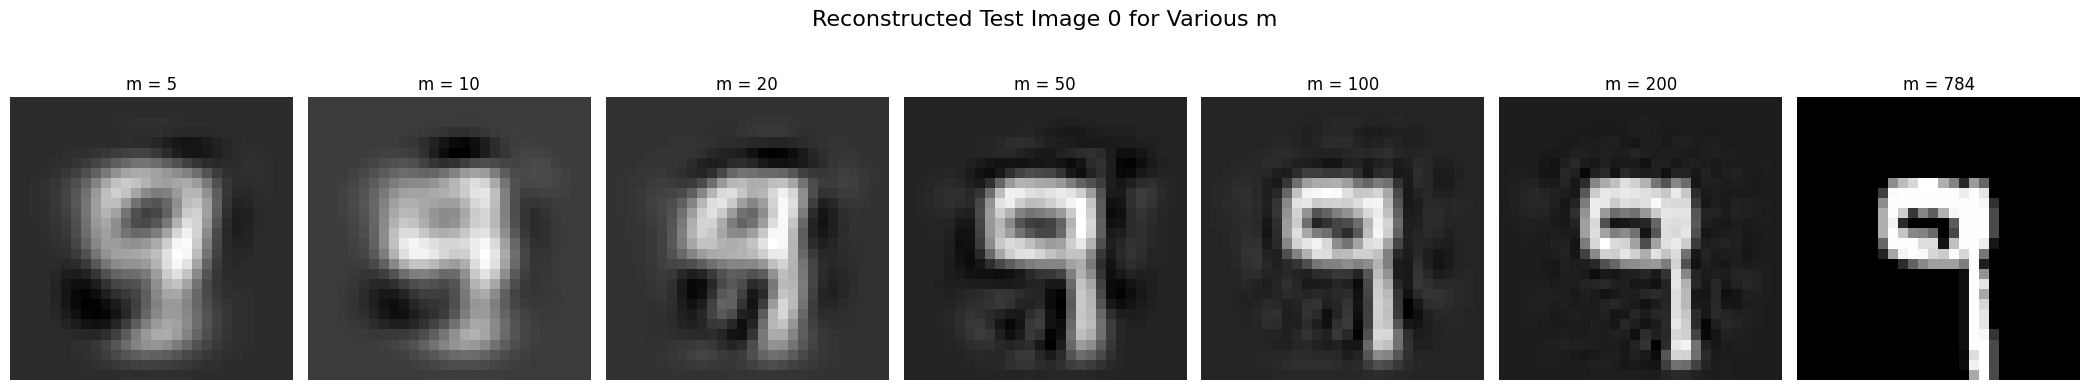

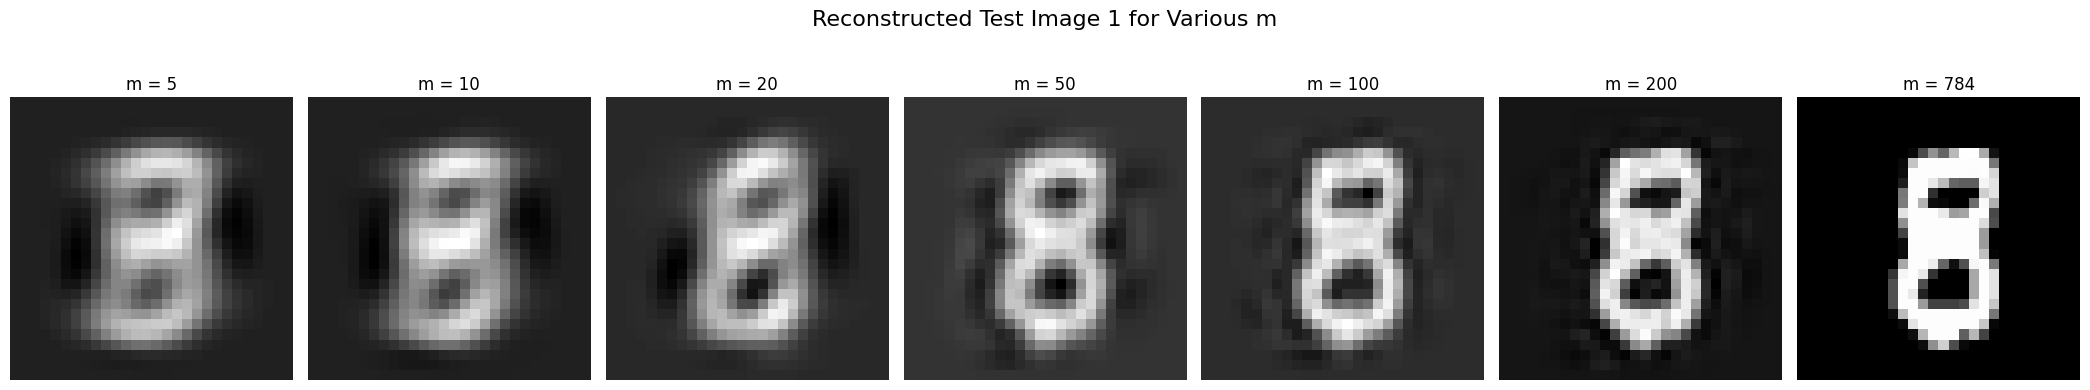

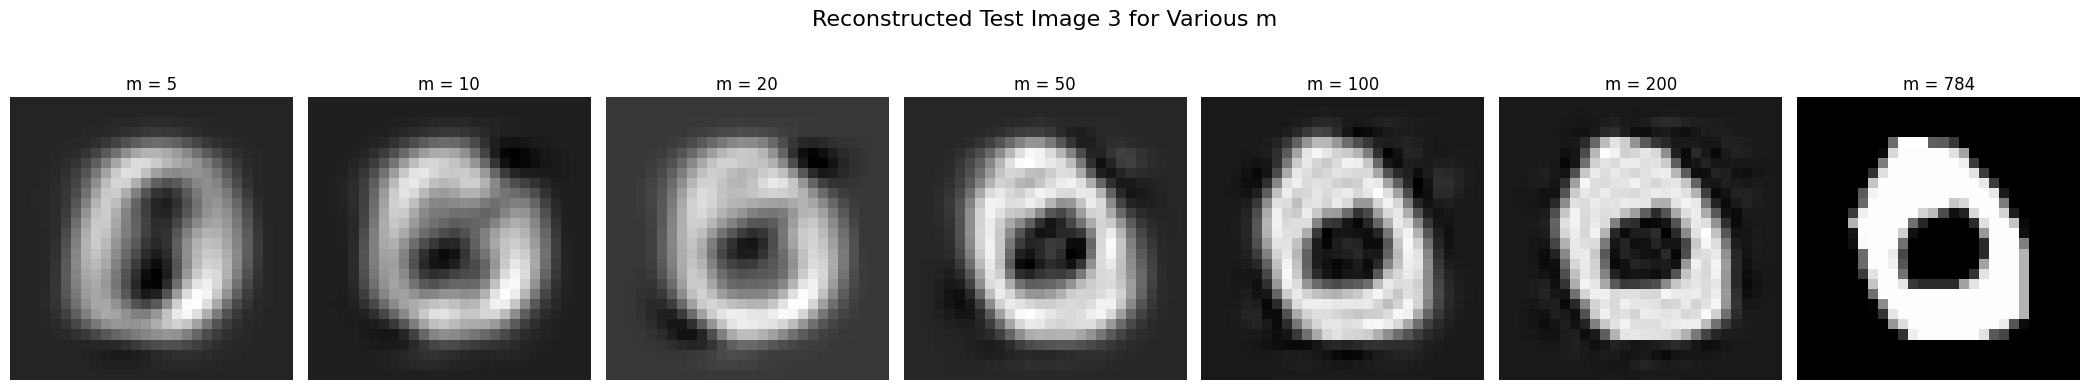

In [15]:
# Compute mean image from the training data (mnist_data).
mean_image = np.mean(mnist_data_training, axis=0)

# ----- Reconstruction of Test Images using Different m values -----
# Choose a test image index (you can experiment with different indices)
for test_index in range(5):
    test_image = mnist_data_test[test_index]  # shape (784,)

    # Define a list of m values to try.
    m_values = [5, 10, 20, 50, 100, 200, 784]  # 784 corresponds to full reconstruction

    # Create subplots to display the reconstructions side by side.
    n_plots = len(m_values)
    plt.figure(figsize=(3 * n_plots, 4))

    for i, m in enumerate(m_values):
        # Get the first m eigenvectors. (Shape: 784 x m)
        eigenvectors_m = eigenvectors[:, :m]

        # Center the test image using the training mean.
        test_image_centered = test_image - mean_image

        # Project the centered test image onto the m principal components.
        projection = np.dot(test_image_centered, eigenvectors_m)  # shape (m,)

        # Reconstruct the image from the m-dimensional projection.
        reconstruction = np.dot(projection, eigenvectors_m.T) + mean_image  # shape (784,)

        # Plot the reconstructed image, reshaped to 28x28.
        plt.subplot(1, n_plots, i + 1)
        plt.imshow(reconstruction.reshape(28, 28), cmap='gray')
        plt.title(f"m = {m}")
        plt.axis('off')

    plt.suptitle(f"Reconstructed Test Image {test_index} for Various m", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

We see that at low m values, with very few principal components, the reconstruction usually only captures some rough shapes/broad strokes of the digit. It is mostly enough to identify the digit in most cases, but finer details are lost and the image is pretty blurry. We see that at high or even full m values, nearly all the variance in the original image is captured and we are able to see a lot of fine details in sharp quality.
The top principal components are likely reflecting the overall contrast or intensity and thus capture the average structure of the digits. Later principal components probably capture variations on the slant and thickness of particular parts of the digits, etc.

## 3d)

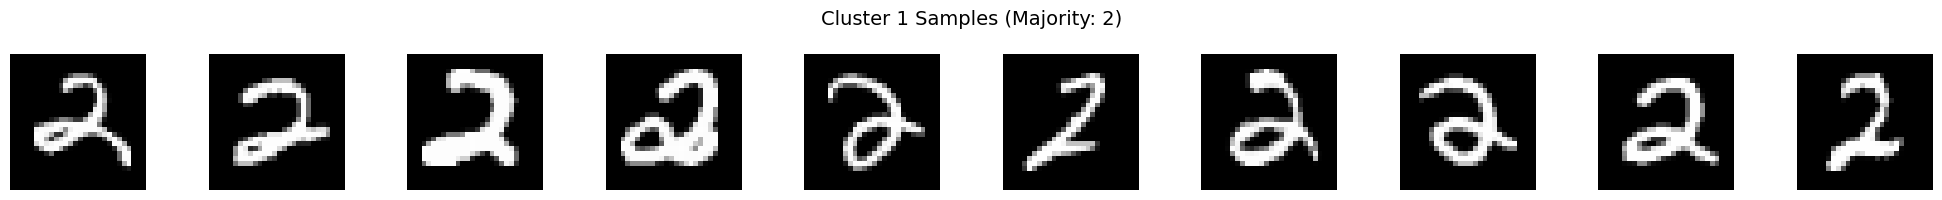

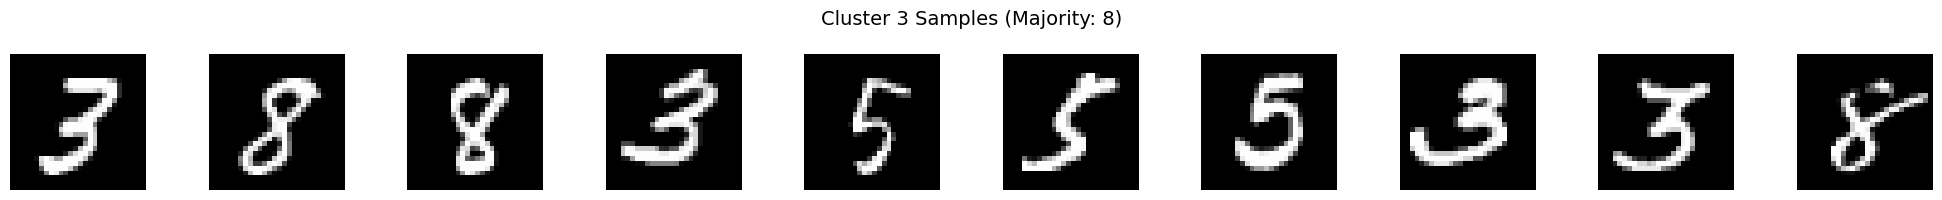

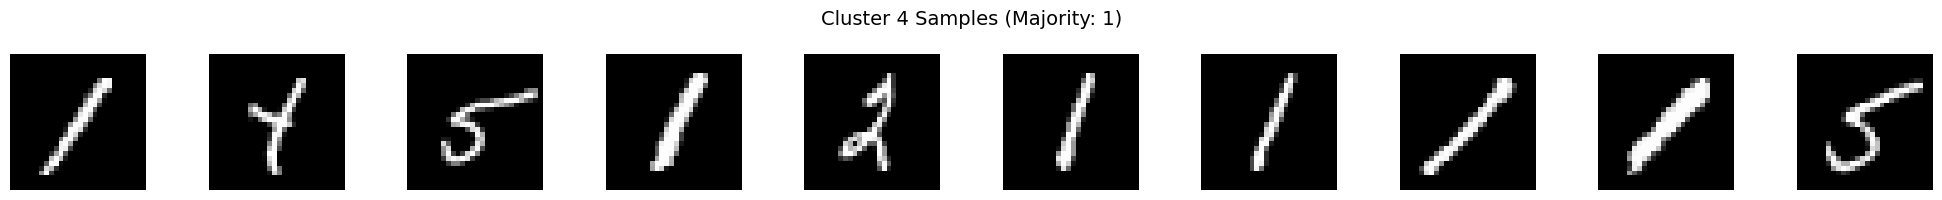

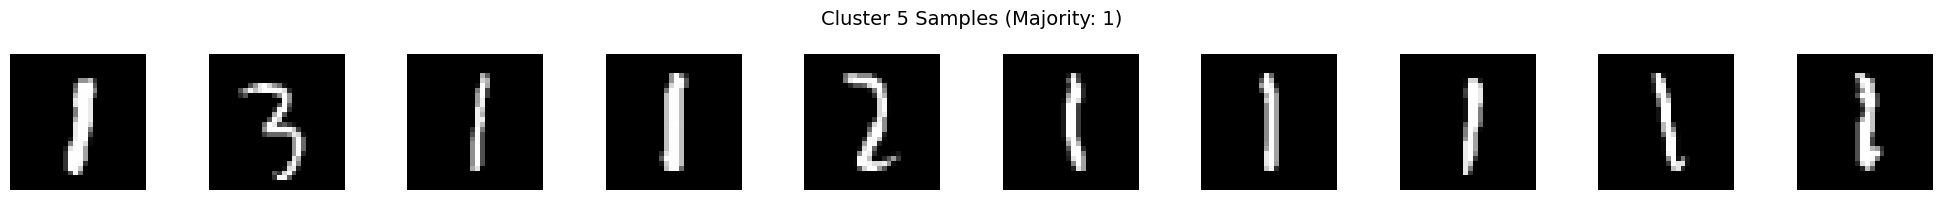

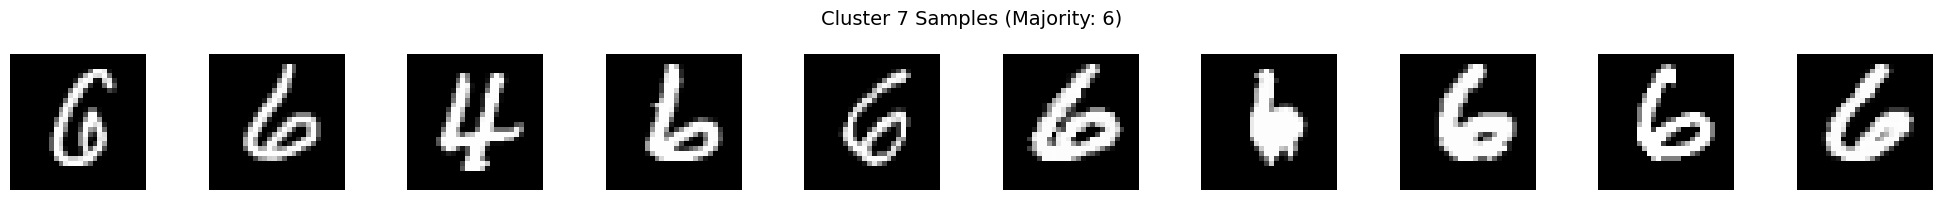

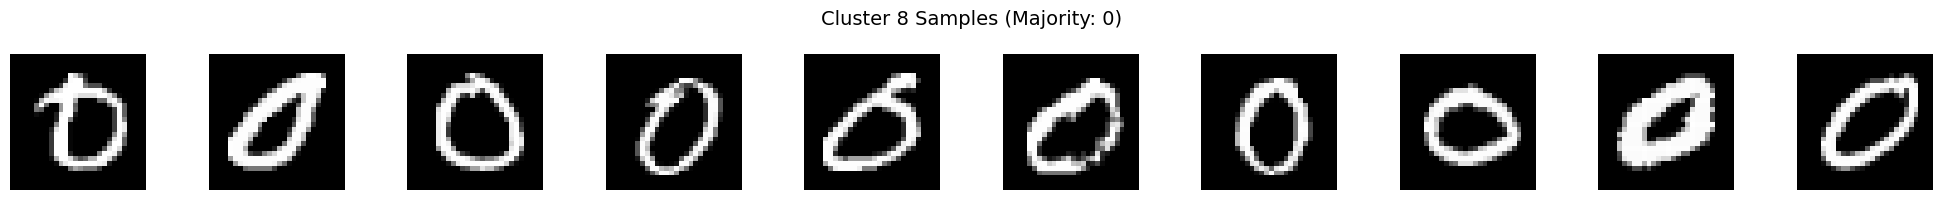

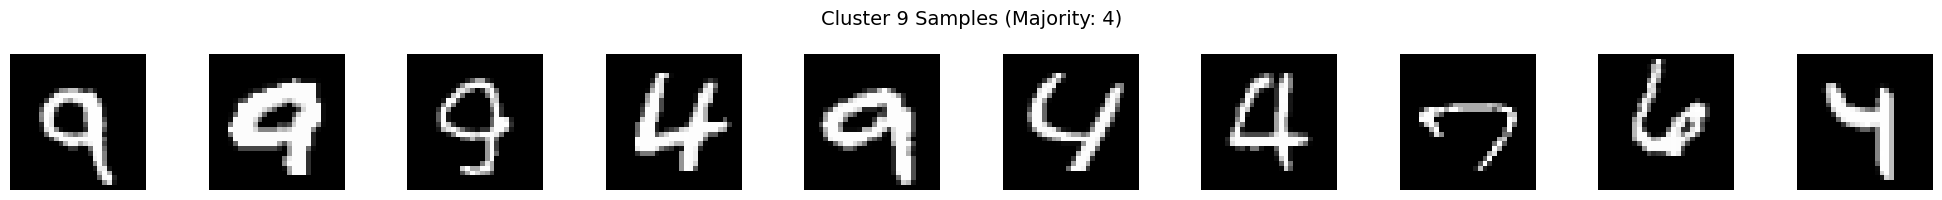

In [16]:
k = 10

# Perform k-means clustering on the raw MNIST data.
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_assignments = kmeans.fit_predict(mnist_data)
cluster_centers = kmeans.cluster_centers_  # Shape (k, 784)

# --- Associate Each Cluster with a Majority Label ---
# For each cluster, we find all indices that belong to that cluster and then compute the most frequent label.
majority_labels = {}
for cluster in range(k):
    indices = np.where(cluster_assignments == cluster)[0]
    # Extract the true labels for data points in this cluster.
    labels_in_cluster = mnist_labels[indices]
    # Compute the majority vote; np.bincount returns counts for each label (0-9).
    if len(labels_in_cluster) > 0:
        majority_label = np.argmax(np.bincount(labels_in_cluster))
    else:
        majority_label = None
    majority_labels[cluster] = majority_label

# --- Plot Cluster Centers ---
# We reshape each center to a 28x28 image.
plt.figure(figsize=(15, 3))
for cluster in range(k):
    plt.subplot(1, k, cluster + 1)
    center_image = cluster_centers[cluster].reshape(28, 28)
    plt.imshow(center_image, cmap='gray')
    plt.title(f'Cluster {cluster}\nMajority: {majority_labels[cluster]}')
    plt.axis('off')
plt.suptitle("K-means Cluster Centers (as 28x28 images)", fontsize=16)
plt.tight_layout()
plt.show()

# --- Plot Sample Images from Each Cluster ---
# For each cluster, we randomly select several images (ex. 10) from the cluster and display them.
for cluster in range(k):
    cluster_indices = np.where(cluster_assignments == cluster)[0]
    # Select up to 10 random images from this cluster.
    num_samples = min(10, len(cluster_indices))
    sample_indices = np.random.choice(cluster_indices, size=num_samples, replace=False)
    
    fig, axs = plt.subplots(1, num_samples, figsize=(2 * num_samples, 2))
    fig.suptitle(f'Cluster {cluster} Samples (Majority: {majority_labels[cluster]})', fontsize=14)
    
    for i, idx in enumerate(sample_indices):
        axs[i].imshow(mnist_data[idx].reshape(28, 28), cmap='gray')
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

These clusters look quite good and seem to reflect the majority digit for the most part -- the two exceptions in the displayed sample are clusters 2 (shows what looks closer to a 9 than a 7) and 9 (shows what looks closer to a 9 than a 4), but both of these cases are relatively similar in shape and somewhat plausible. 

## 3e)

In [17]:
X = (mnist_data >= 0.5).astype(float)  # X now contains only 0's and 1's
N, d = X.shape  # N: number of examples, d: 784


Running EM for M = 10 components:
Iteration 0: log-likelihood = -20531578880.00
Iteration 1: log-likelihood = -19663329280.00
Iteration 2: log-likelihood = -17525104640.00
Iteration 3: log-likelihood = -17060100096.00
Iteration 4: log-likelihood = -16860477440.00
Iteration 5: log-likelihood = -16767853568.00
Iteration 6: log-likelihood = -16724849664.00
Iteration 7: log-likelihood = -16697985024.00
Iteration 8: log-likelihood = -16670689280.00
Iteration 9: log-likelihood = -16645875712.00
Iteration 10: log-likelihood = -16619127808.00
Iteration 11: log-likelihood = -16595512320.00
Iteration 12: log-likelihood = -16572355584.00
Iteration 13: log-likelihood = -16547316736.00
Iteration 14: log-likelihood = -16525089792.00
Iteration 15: log-likelihood = -16504406016.00
Iteration 16: log-likelihood = -16487075840.00
Iteration 17: log-likelihood = -16474158080.00
Iteration 18: log-likelihood = -16463736832.00
Iteration 19: log-likelihood = -16455538688.00
Iteration 20: log-likelihood = -164


Running EM for M = 20 components:
Iteration 0: log-likelihood = -20557717504.00
Iteration 1: log-likelihood = -19717079040.00
Iteration 2: log-likelihood = -16650326016.00
Iteration 3: log-likelihood = -15740649472.00
Iteration 4: log-likelihood = -15490841600.00
Iteration 5: log-likelihood = -15391213568.00
Iteration 6: log-likelihood = -15339681792.00
Iteration 7: log-likelihood = -15307294720.00
Iteration 8: log-likelihood = -15289390080.00
Iteration 9: log-likelihood = -15276831744.00
Iteration 10: log-likelihood = -15266575360.00
Iteration 11: log-likelihood = -15258230784.00
Iteration 12: log-likelihood = -15252190208.00
Iteration 13: log-likelihood = -15247452160.00
Iteration 14: log-likelihood = -15243430912.00
Iteration 15: log-likelihood = -15240445952.00
Iteration 16: log-likelihood = -15237941248.00
Iteration 17: log-likelihood = -15236067328.00
Iteration 18: log-likelihood = -15234437120.00
Iteration 19: log-likelihood = -15232232448.00
Iteration 20: log-likelihood = -152

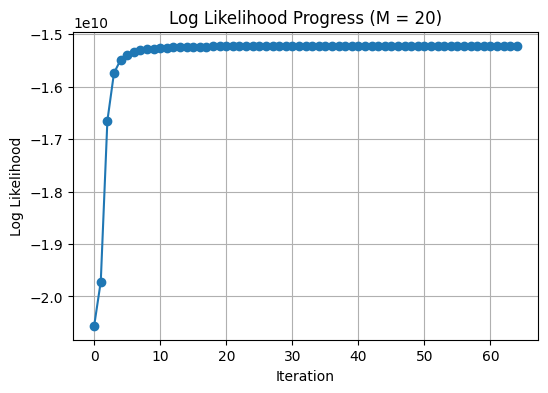


--- Clustering Results for M = 10 ---


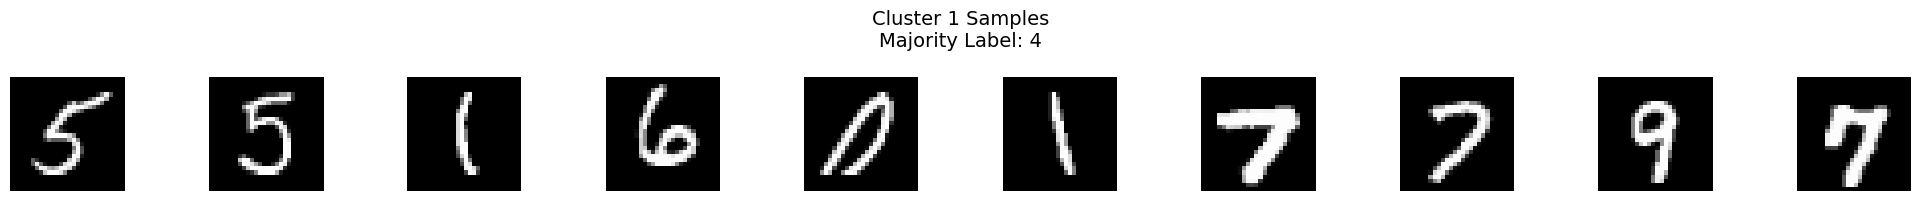

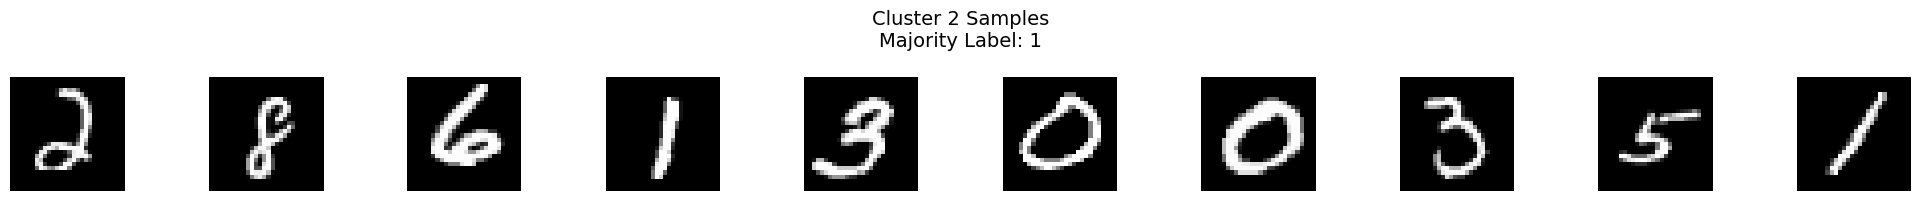

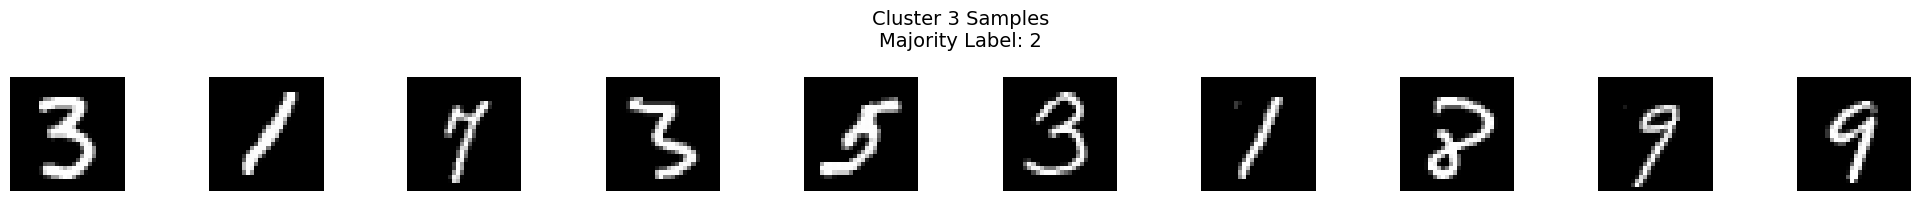

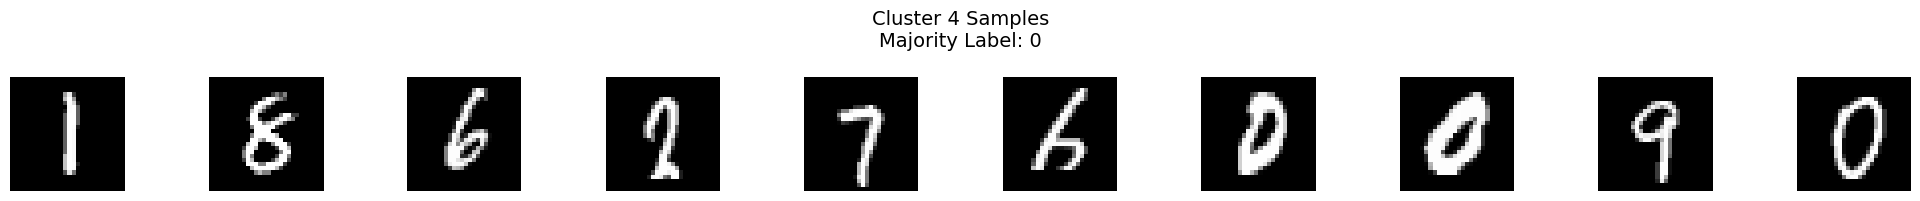

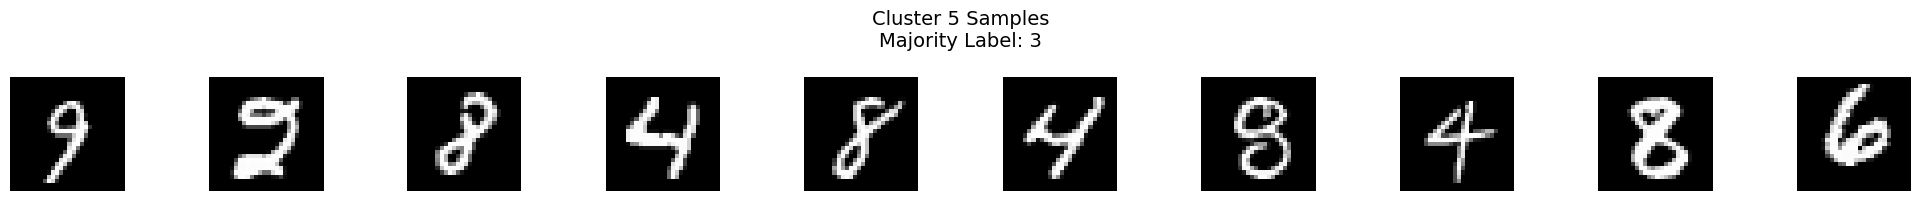

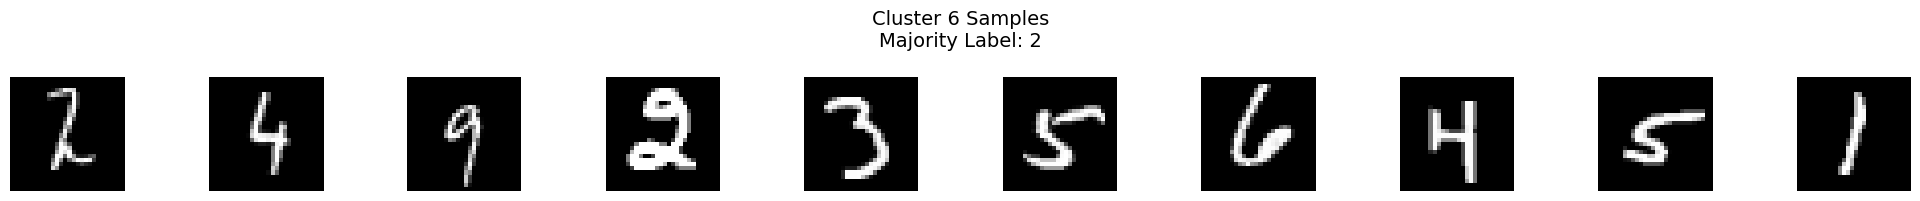

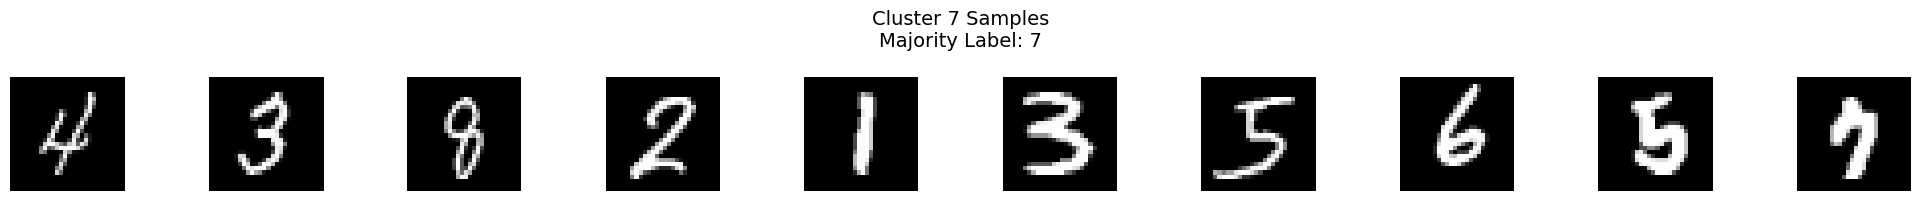

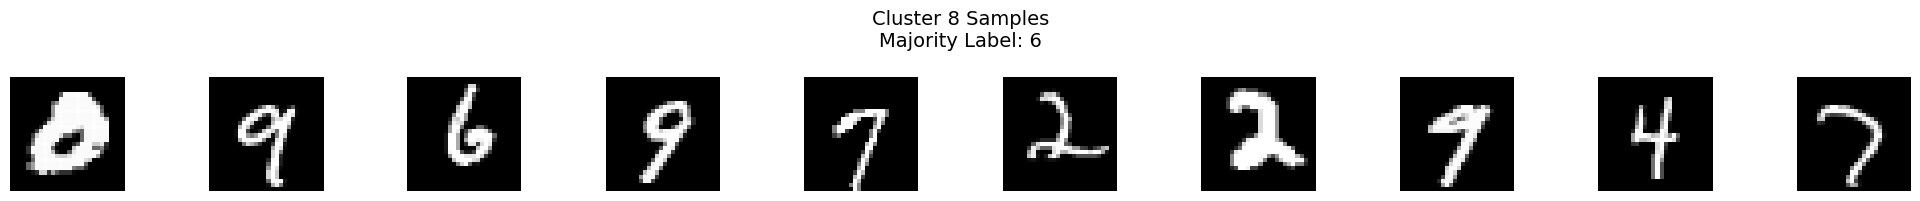

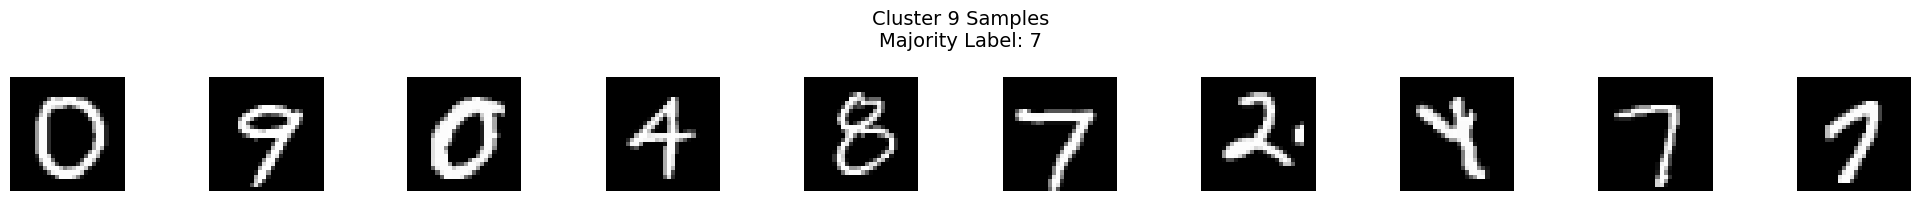

Majority labels per cluster: {0: 1, 1: 4, 2: 1, 3: 2, 4: 0, 5: 3, 6: 2, 7: 7, 8: 6, 9: 7}

--- Clustering Results for M = 20 ---


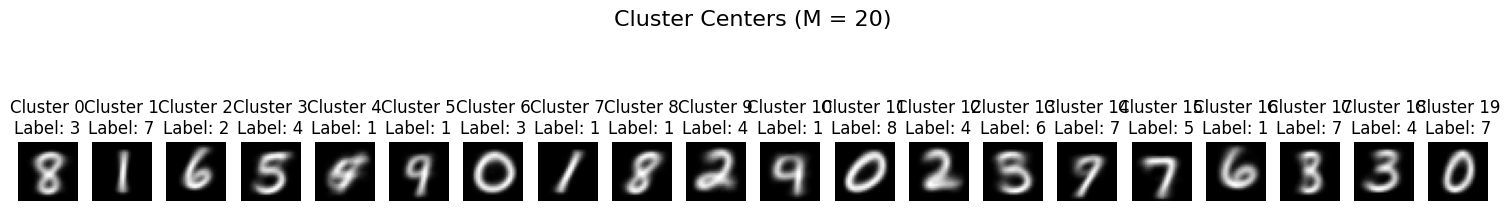

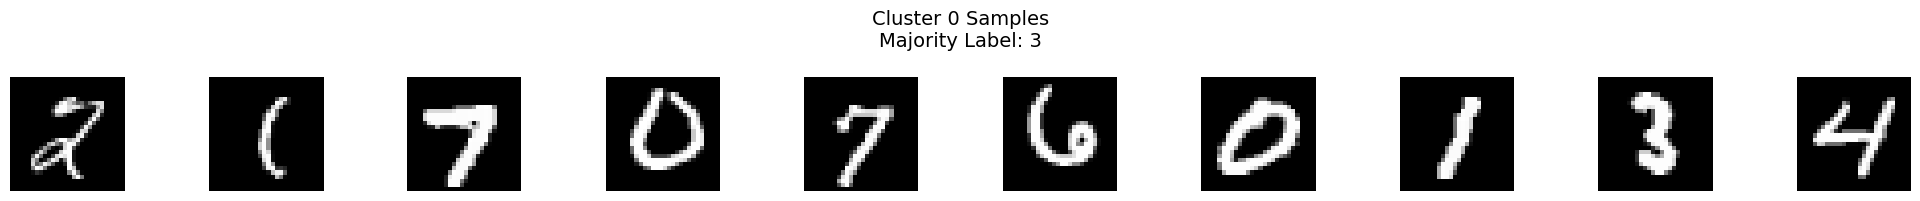

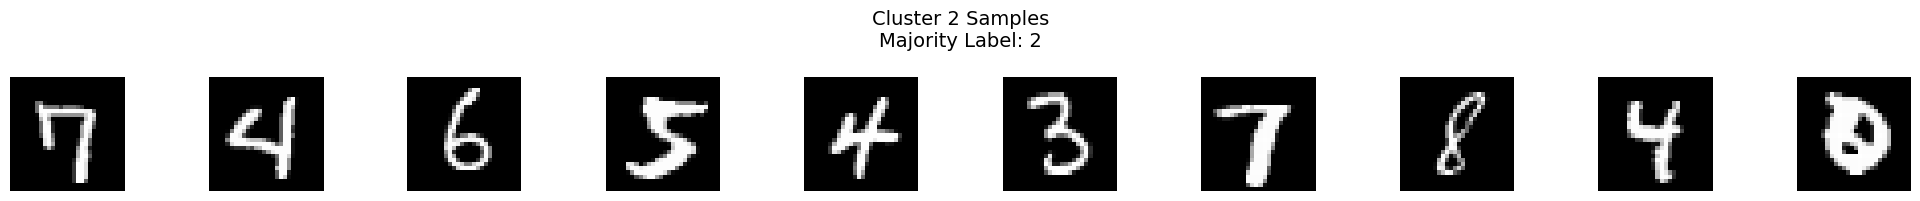

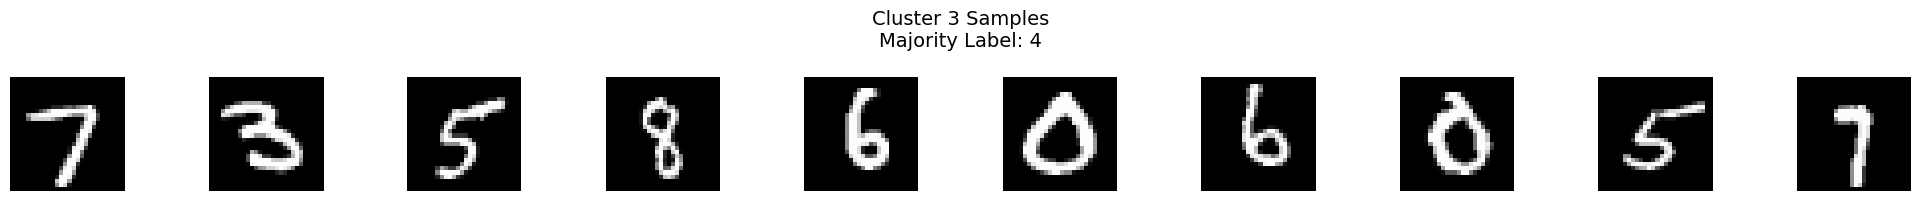

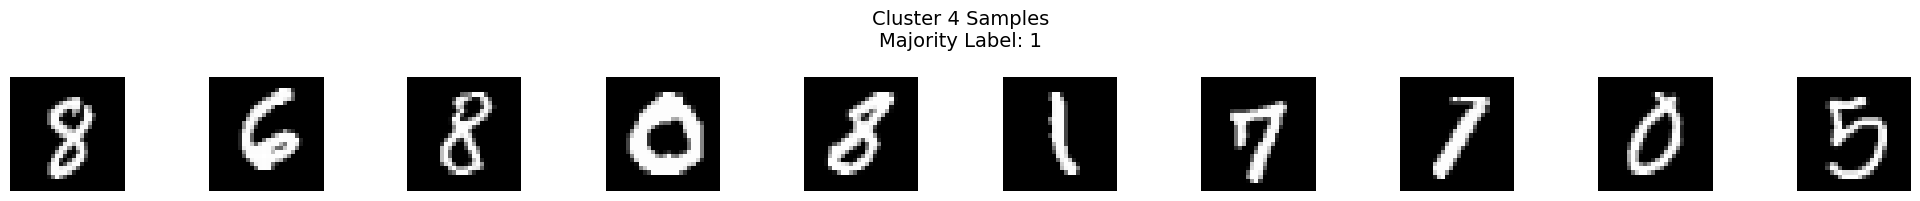

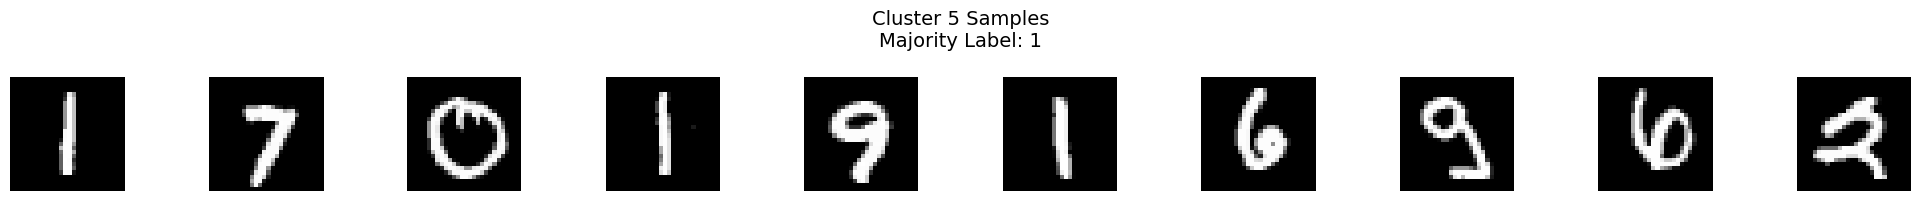

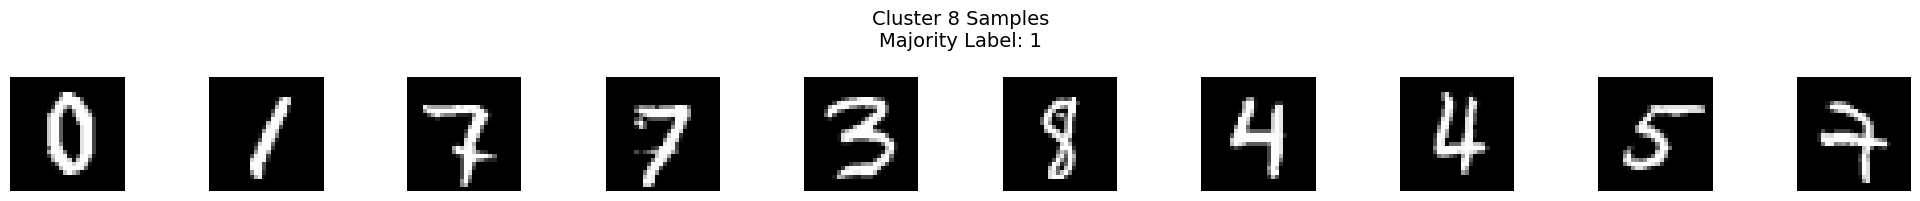

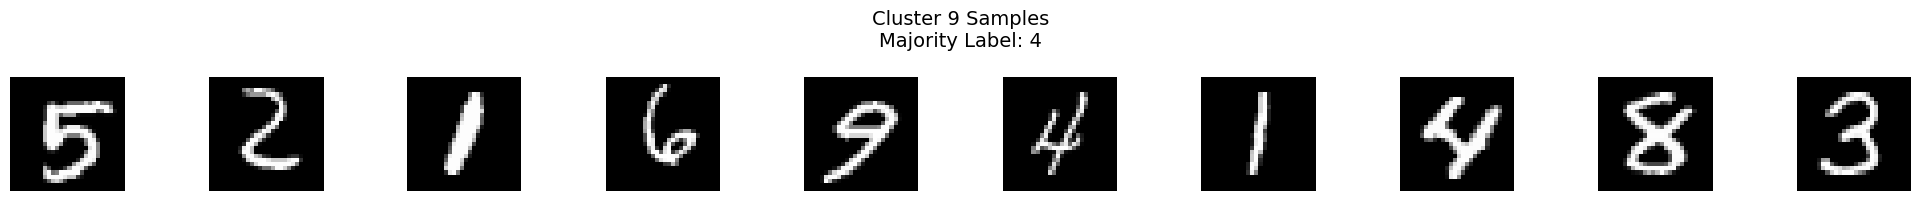

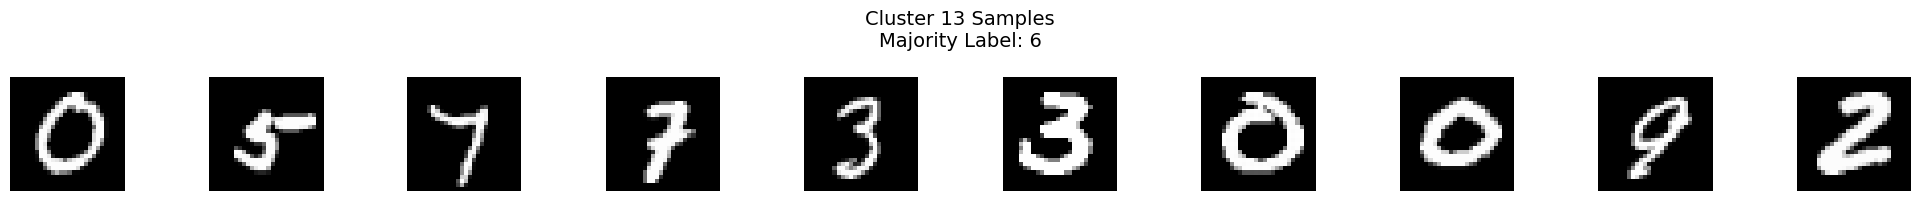

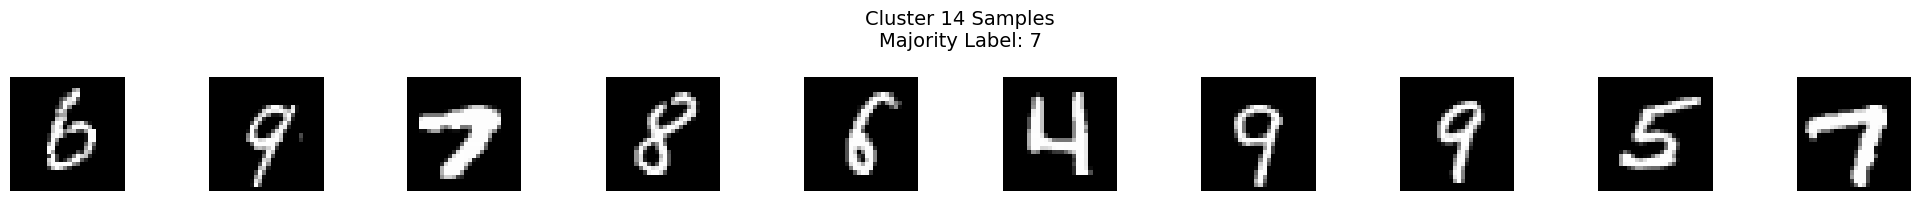

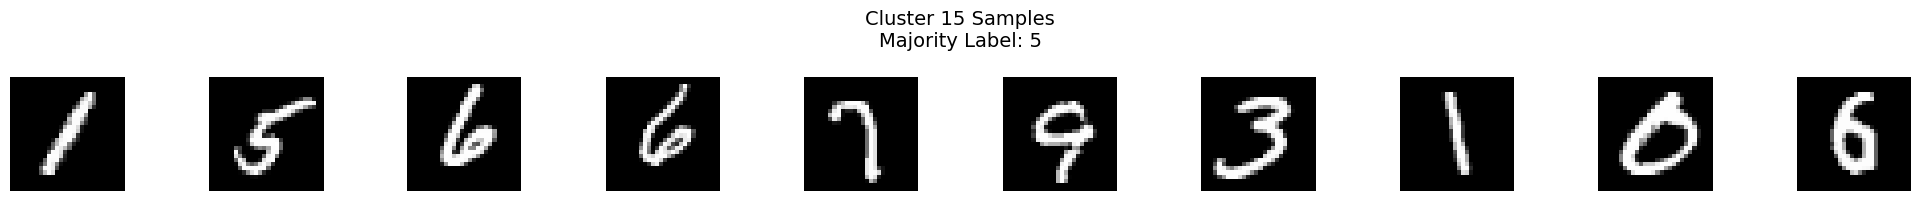

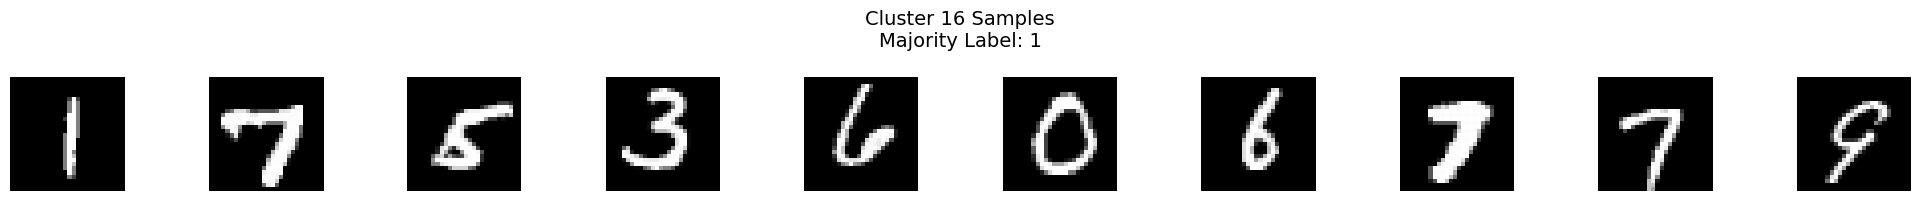

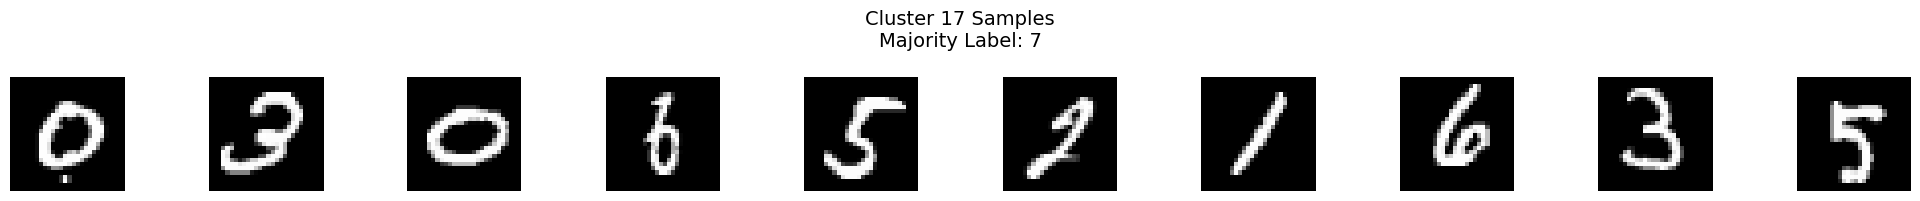

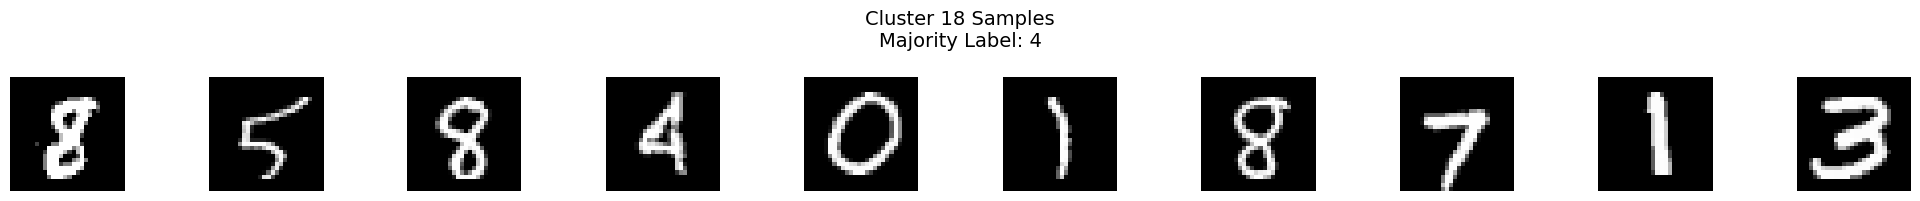

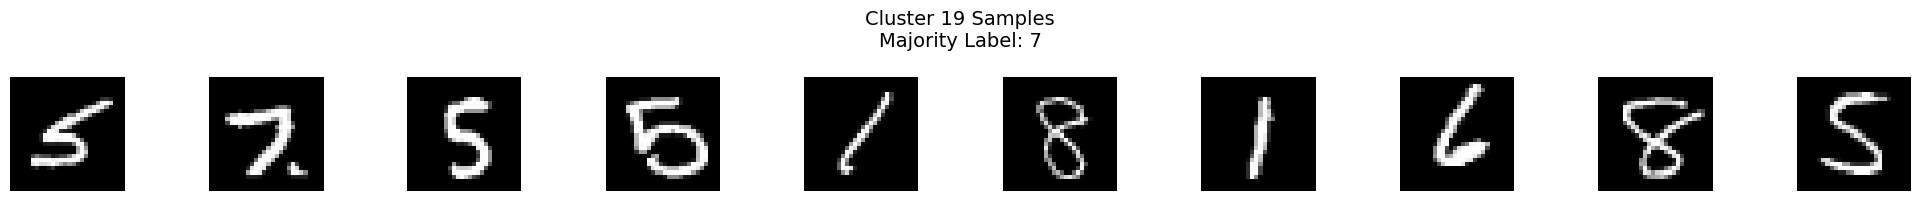

Majority labels per cluster: {0: 3, 1: 7, 2: 2, 3: 4, 4: 1, 5: 1, 6: 3, 7: 1, 8: 1, 9: 4, 10: 1, 11: 8, 12: 4, 13: 6, 14: 7, 15: 5, 16: 1, 17: 7, 18: 4, 19: 7}


In [18]:
def em_bernoulli_mixture(X, M, max_iter=100, tol=1e-4):
    """
    EM for a mixture of Bernoulli distributions.

    Parameters:
      X       : (N, d) binarized data matrix (assumed to be float32).
      M       : Number of mixture components.
      max_iter: Maximum number of iterations.
      tol     : Tolerance for convergence (change in log-likelihood).

    Returns:
      pi             : (M,) mixing weights.
      p              : (M, d) matrix of per-pixel probabilities.
      responsibilities: (N, M) matrix with responsibility values.
      log_likelihoods: List of log-likelihood values per iteration.
    """
    N, d = X.shape
    # Initialize responsibilities randomly (float32)
    w = np.random.rand(N, M).astype(np.float32)
    w = w / w.sum(axis=1, keepdims=True)

    log_likelihoods = []

    for iteration in range(max_iter):
        # M-Step: Update mixing weights and component parameters.
        pi = w.sum(axis=0) / N  # shape (M,)
        # Update p with Laplace smoothing.
        p = (w.T.dot(X) + 1.0) / (w.sum(axis=0)[:, None] + 2.0)  # shape (M, d)

        # E-Step: Compute log probabilities.
        # Compute X.dot(log(p.T)) and (1 - X).dot(log((1 - p).T))
        log_prob = X.dot(np.log(p.T + 1e-10)) + (1 - X).dot(np.log((1 - p).T + 1e-10))
        log_prob += np.log(pi + 1e-10)  # shape (N, M)

        # Stabilize the computation
        log_prob_max = np.max(log_prob, axis=1, keepdims=True)
        log_prob_stable = np.exp(log_prob - log_prob_max)
        sum_prob = log_prob_stable.sum(axis=1, keepdims=True)
        w = log_prob_stable / sum_prob  # Updated responsibilities

        # Compute current log likelihood
        current_log_likelihood = np.sum(np.log(sum_prob) + log_prob_max.ravel())
        log_likelihoods.append(current_log_likelihood)

#         if iteration % 10 == 0:
        print(f"Iteration {iteration}: log-likelihood = {current_log_likelihood:.2f}")
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print(f"Converged at iteration {iteration}.")
            break

    return pi, p, w, log_likelihoods

# Use float32 for the binarized MNIST data.
X = (mnist_data >= 0.5).astype(np.float32)
subset_indices = np.random.choice(np.arange(X.shape[0]), size=10000, replace=False)
X_subset = X[subset_indices]

# ---------------------------
# 3. Run the EM Algorithm for M = 10 and M = 20
# ---------------------------
results = {}  # dictionary to store results for different values of M

for M in [10, 20]:
    print(f"\nRunning EM for M = {M} components:")
    pi, p, responsibilities, log_likelihoods = em_bernoulli_mixture(X_subset, M, max_iter=200, tol=1e-4)
    results[M] = {
        'pi': pi,
        'p': p, 
        'w': responsibilities,
        'log_likelihoods': log_likelihoods
    }
    # Plot the log likelihood curve.
    plt.figure(figsize=(6, 4))
    plt.plot(log_likelihoods, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("Log Likelihood")
    plt.title(f"Log Likelihood Progress (M = {M})")
    plt.grid(True)
    plt.show()

# ---------------------------
# 4. Visualize Cluster Centers and Associate with Majority Labels
# ---------------------------
# For each model (M = 10 and 20), we:
#  (a) Show each component's parameter vector reshaped to 28x28.
#  (b) Assign each training example to its most likely component.
#  (c) Compute the majority true label in each cluster.
#  (d) Display a few example images from each cluster.
def display_clusters(M, results, num_samples=10):
    p = results[M]['p']  # shape (M, 784)
    w = results[M]['w']  # shape (N, M)
    
    # Assign each data point to the component with highest responsibility.
    assignments = np.argmax(w, axis=1)  # shape (N,)
    
    # Compute the majority label for each cluster.
    majority_labels = {}
    for m in range(M):
        indices = np.where(assignments == m)[0]
        if len(indices) > 0:
            labels_in_cluster = mnist_labels[indices]
            majority_labels[m] = np.argmax(np.bincount(labels_in_cluster))
        else:
            majority_labels[m] = None
    
    # Plot the cluster centers.
    plt.figure(figsize=(15, 3))
    for m in range(M):
        plt.subplot(1, M, m + 1)
        center_image = p[m].reshape(28, 28)
        plt.imshow(center_image, cmap='gray')
        plt.title(f"Cluster {m}\nLabel: {majority_labels[m]}")
        plt.axis("off")
    plt.suptitle(f"Cluster Centers (M = {M})", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # For each cluster, display a few example images.
    for m in range(M):
        indices = np.where(assignments == m)[0]
        if len(indices) == 0:
            continue
        # Select up to num_samples random examples from this cluster.
        sel = np.random.choice(indices, size=min(num_samples, len(indices)), replace=False)
        fig, axs = plt.subplots(1, len(sel), figsize=(2*len(sel), 2))
        fig.suptitle(f"Cluster {m} Samples\nMajority Label: {majority_labels[m]}", fontsize=14)
        for ax, idx in zip(axs, sel):
            ax.imshow(mnist_data[idx].reshape(28, 28), cmap='gray')
            ax.axis("off")
        plt.tight_layout()
        plt.show()
    
    print("Majority labels per cluster:", majority_labels)
    
# Display clustering results for M = 10 and M = 20.
for M in [10, 20]:
    print(f"\n--- Clustering Results for M = {M} ---")
    display_clusters(M, results)

We see that from M = 10 to M=20 the images get significantly sharper and are overall identifiable even at M=10.